# Usual Package Imports

In [13]:
import networkx as nx, numpy as np, matplotlib.pyplot as plt, re, yaml,sys, shelve
from datetime import datetime,date
from collections import defaultdict
from functools import reduce
from importlib import reload
today = re.sub('-','_',str(date.today()))
today

'2020_04_15'

# Change Directory - Revise for your file system.

In [14]:
s = %pwd
if not re.search('Downloads$',s):
    %cd Downloads

C:\Users\nlgun\Downloads


## Open a shelve and load a graph and a term dictionary

In [15]:
with shelve.open('definitions') as f:
    graphdict = dict([(k,v) for k,v in f.items()])
graph,termdict = [graphdict[k] for k in 'graph term_dictionary'.split()]
list(graphdict.keys())

['graph', 'term_dictionary']

In [16]:
g = graph.copy()
len(g)

192

## Test the Graph

In [17]:
term = 'Senior Reduction Amount'
term0 = 'Tranche Write-up Amount' # a second term
g.in_edges(term)

[('Delinquency Test', 'Senior Reduction Amount'),
 ('Scheduled Principal', 'Senior Reduction Amount'),
 ('Unscheduled Principal', 'Senior Reduction Amount'),
 ('Payment Date', 'Senior Reduction Amount'),
 ('Recovery Principal', 'Senior Reduction Amount'),
 ('Minimum Credit Enhancement Test', 'Senior Reduction Amount')]

In [18]:
[(edge[0],termdict[edge[0]]) for edge in g.in_edges('Senior Reduction Amount')]

[('Delinquency Test',
  [(1837,
    'The "Delinquency Test" for any Payment Date and Loan Group is a test that will be satisfied if: (a) the sum of the Distressed Principal Balance for such Loan Group for the current Payment Date and each of the preceding five Payment Dates, divided by six, is less than (b) 40% of the excess of (i) the product of (x) the Subordinate Percentage and (y) the aggregate UPB of the Reference Obligations in such Loan Group as of the preceding Payment Date over (ii) the Principal Loss Amount for such Loan Group for the current Payment Date.')]),
 ('Scheduled Principal',
  [(1831,
    '"Scheduled Principal" with respect to any Payment Date and Loan Group is the sum of all monthly scheduled payments of principal due (whether with respect to the related Reporting Period or any prior Reporting Period) on the Reference Obligations in that Loan Group and reported to Fannie Mae and collected by the related servicer during the related Reporting Period.')]),
 ('Unsched

In [123]:
def make_definition_graph(term_,g=g):
    g0= nx.DiGraph()
    g0.add_edges_from(g.in_edges(term_))
    return g0

In [124]:
def draw_g(g,sz = (20,20)):
    plt.figure(1,figsize=sz)
    nx.draw_networkx(g)
    plt.show()

In [130]:
def make_draw_graph(term_,g=g,sz=(20,20)):
    draw_g(make_definition_graph(term_,g),sz)

## Drill down on definitions

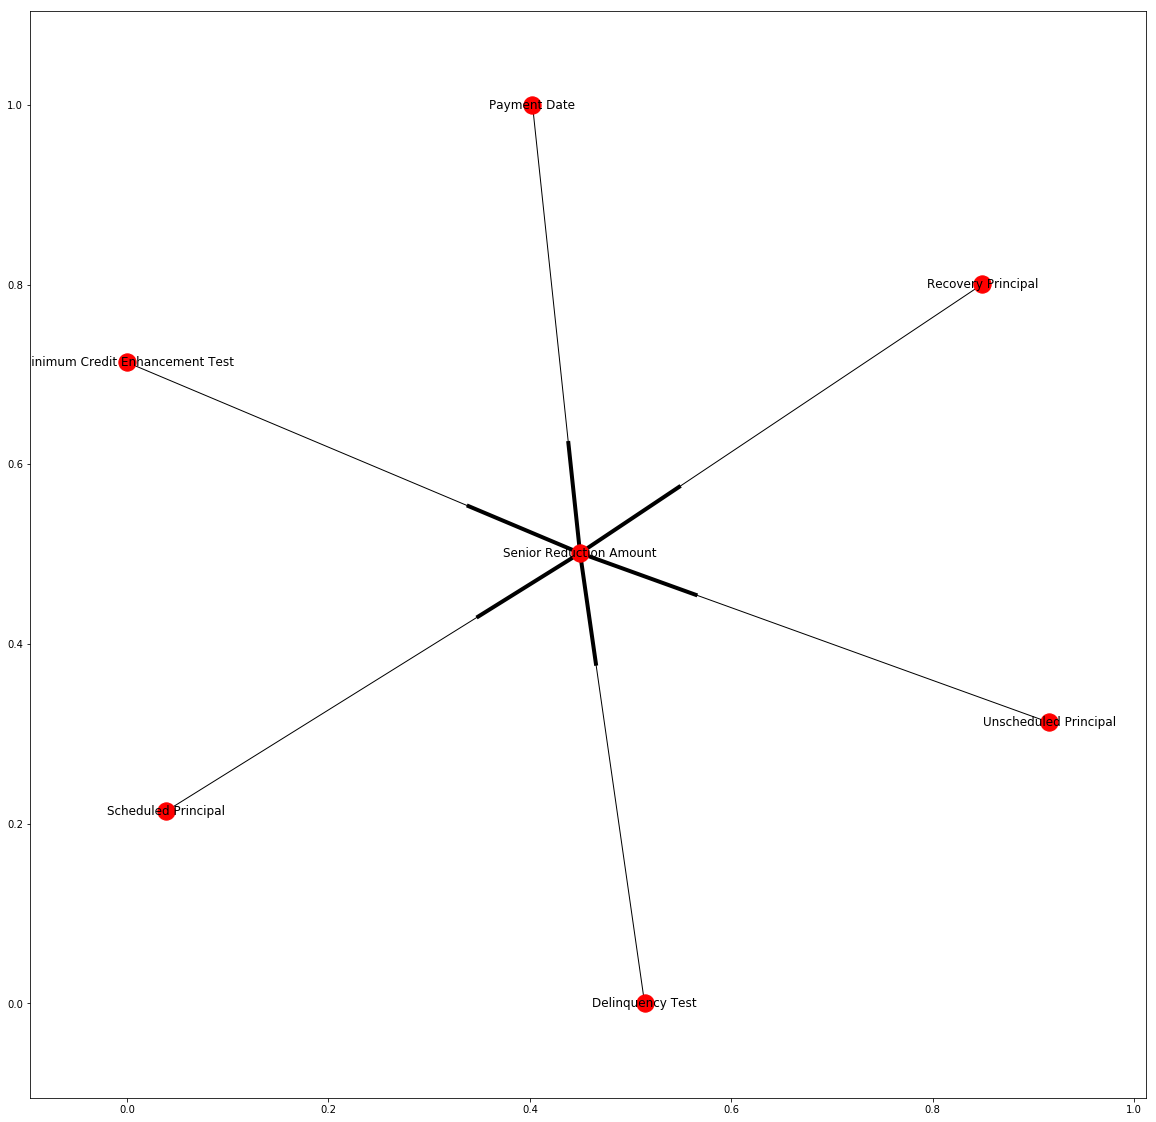

In [126]:
make_draw_graph(term) # term = Senior Reduction Amount

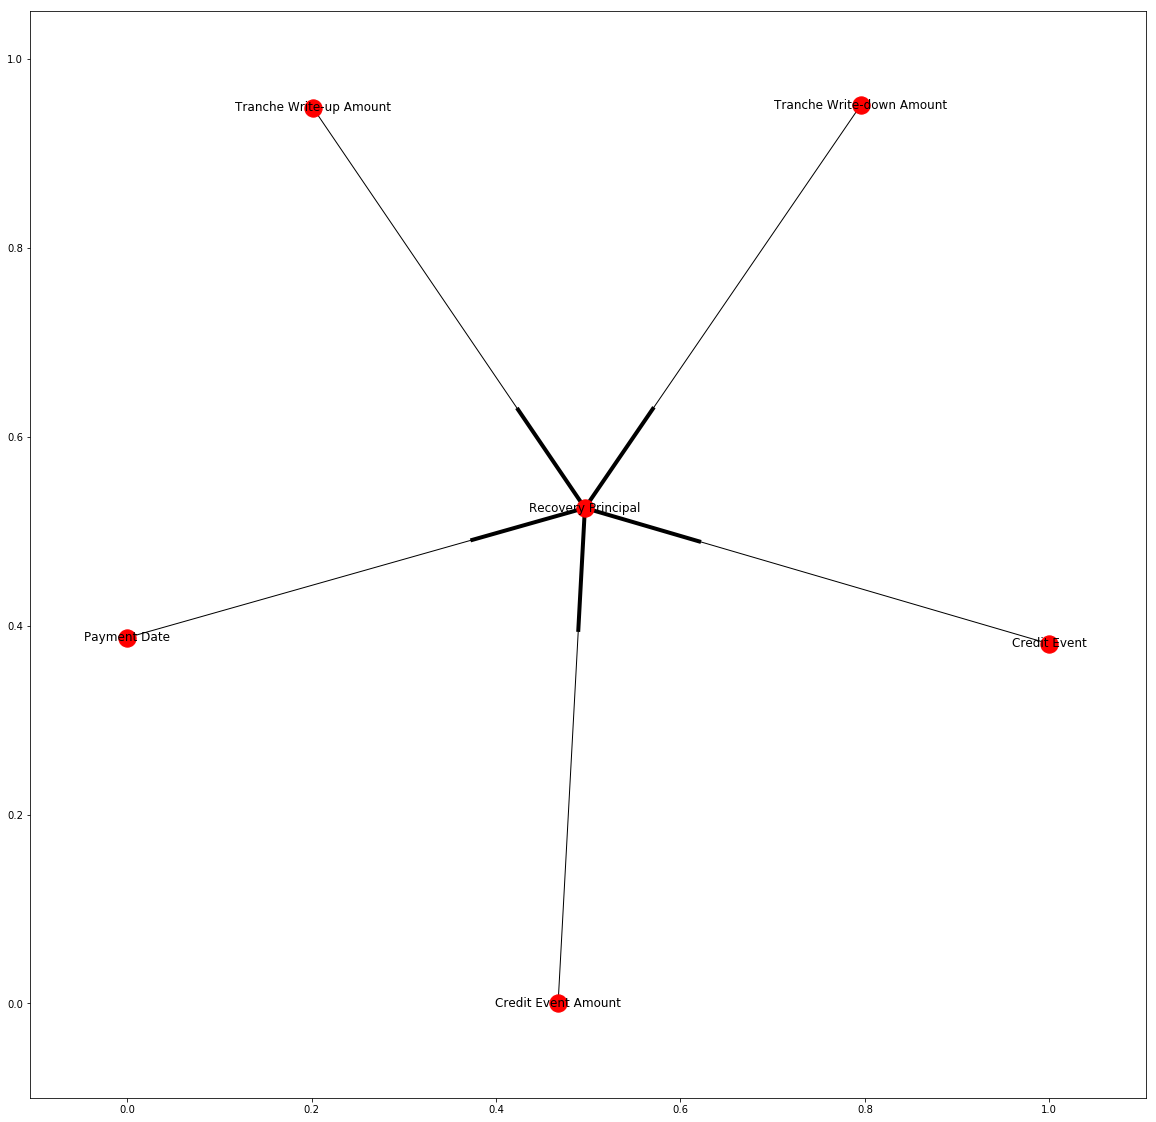

In [127]:
make_draw_graph('Recovery Principal')

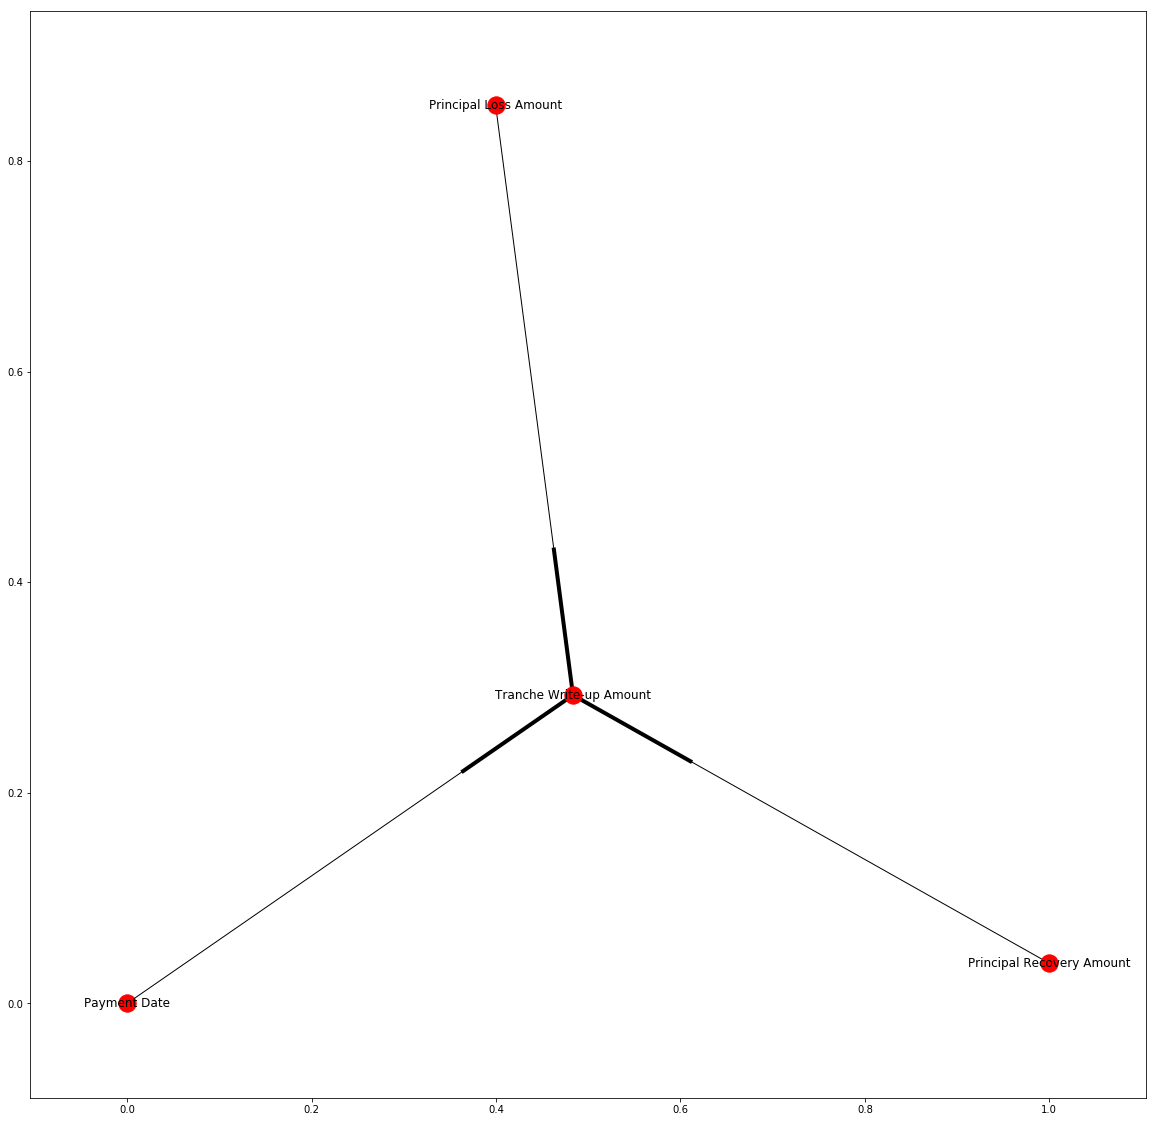

In [128]:
make_draw_graph(term0)

In [22]:
g.in_edges('Tranche Write-up Amount')

[('Principal Recovery Amount', 'Tranche Write-up Amount'),
 ('Payment Date', 'Tranche Write-up Amount'),
 ('Principal Loss Amount', 'Tranche Write-up Amount')]

# Import our Custom Code for Tracing Back Definitions through other Definitions

In [23]:
import graphutils
reload(graphutils)
gutils = graphutils.GraphUtils

## Test Traceback

In [24]:
ar = []
lst = lambda x: ar.append(x)
lg = gutils.traceback(g.copy(),term0,num=5,it=0,f=lst)
print(len(lg.edges()),len(g.edges()),len(g.in_edges('Tranche Write-up Amount')))
#lg = gutils.traceback(g.copy(),'Senior Reduction Amount',num=3)
#draw_g(lg)
g.in_edges(term0),termdict[term0]

66 761 3


([('Principal Recovery Amount', 'Tranche Write-up Amount'),
  ('Payment Date', 'Tranche Write-up Amount'),
  ('Principal Loss Amount', 'Tranche Write-up Amount')],
 [(1876,
   'Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.')])

In [25]:
ar.sort()
ar

[(0, 'Payment Date'),
 (0, 'Principal Loss Amount'),
 (0, 'Principal Recovery Amount'),
 (1, 'Book-Entry Notes'),
 (1, 'Business Day'),
 (1, 'Credit Event'),
 (1, 'Credit Event Net Gain'),
 (1, 'Credit Event Net Loss'),
 (1, 'Credit Event Reference Obligation'),
 (1, 'Definitive Notes'),
 (1, 'Liquidation Proceeds'),
 (1, 'Modification Loss Amount'),
 (1, 'Net Liquidation Proceeds'),
 (1, 'Period'),
 (1, 'Record Date'),
 (1, 'Reference Obligations'),
 (1, 'Reporting Period'),
 (1, 'Warrant'),
 (2, 'Clearstream'),
 (2, 'Credit Event UPB'),
 (2, 'Current Accrual Rate'),
 (2, 'Cut-off Date'),
 (2, 'Euroclear'),
 (2, 'Group Termination Date'),
 (2, 'Modification Event'),
 (2, 'Mortgage Insurance Credit Amount'),
 (2, 'Note Owners'),
 (2, 'Original Accrual Rate'),
 (2, 'Reference Pool'),
 (2, 'Treasury'),
 (2, 'Wells Fargo'),
 (2, 'Wells Fargo Bank'),
 (3, 'Barclays'),
 (3, 'BofA Merrill'),
 (3, 'Citigroup'),
 (3, 'Clearstream International'),
 (3, 'Credit Suisse'),
 (3, 'Dealer'),
 (3, 'De

In [26]:
term0,termdict[term0]

('Tranche Write-up Amount',
 [(1876,
   'Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.')])

# A sketch of "memoizing"

In [27]:
def memo(f):
    """Decorator that caches the return value for each call to f(args).
    Then when called again with same args, we can just look it up."""
    cache = {}
    def _f(*args):
        try:
            if args in cache: print("found it")
            return cache[args]
        except KeyError:
            cache[args] = result = f(*args)
            return result
        except TypeError:
            # some element of args can't be a dict key
            return f(args)
    return _f
@memo # f = memo(f) = _f
def f(x):return x*2
f(3)
f(3)

found it


6

# Converting definition lists to readable text and to formulae

# A General Recursion with an (Ac)Cumulator

In [36]:
# decorate a function (see below) with an (ac)cumulator
# control the number of recursion with limit = num
# include a function newargs_ for generating new arguments from the old args
def decf(f,newargs_,cum = None,num=2, it = 0):
    cum = cum or [] # cum is the accumulation of the recursion
    def f_(*args,num=num,it=it):
        #print('args',args) # DEBUG
        cum.append(f(*args)) # cache the result of f applied to the arguments
        if it <= num: # recurse if under the limit
            newargs = newargs_(*args)
            for args in newargs:
                f_(*args,num=num,it=it+1)
    return f_,cum

# A toy example with trivial functions as arguments
# We need to have access to the cumulator so the decorator returns it 
func,cum = decf(lambda x: x, lambda x: ([x+1],))
print(cum) # empty
func(0)
print(cum )
func(0)
print(cum)
# the accumulator is persistent
print(cum) # accumulator
func,cum = decf(lambda x: x, lambda x: ([x+1],))
# the (only) way to get a new accumulator
func(0)
print(cum)

[]
[0, 1, 2, 3]
[0, 1, 2, 3, 0, 1, 2, 3]
[0, 1, 2, 3, 0, 1, 2, 3]
[0, 1, 2, 3]


In [37]:
dlm = (': ',', ','\n') # various delimiters for use in string formation

## Turn a definition into a string

In [38]:
get_def = lambda term,g=g,dct = termdict: dlm[0].join((term, dlm[-1].join((tpl[1] for tpl in dct[term]))))
get_def(term0)

'Tranche Write-up Amount: Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.'

In [39]:
get_def('Tranche Write-up Amount')

'Tranche Write-up Amount: Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.'

## Indent the definition string for readability

In [47]:
# indent based on level
get_def_indent = lambda x,indent=0: '\t'*indent + get_def(x)
get_def_indent(term0,2)

'\t\tTranche Write-up Amount: Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.'

## Using the recursion to write an indented dictionary of terms

In [41]:
func,cum = decf(get_def_indent,lambda term,it: ([indedge[0],it+1]
                for indedge in g.in_edges(term)))
print(cum) # empty cumulator
func(term, 0,num = 0) # fill it
cum[:5]

[]


['Senior Reduction Amount: Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.',
 '\tDelinquency Test: The "Delinquency Test" for any Payment Date and Loan Group is a test that will be sati

In [42]:
# using the recursion 
func,cum = decf(get_def_indent,lambda term,it: ([indedge[0],it+1]
                for indedge in g.in_edges(term)))
print(cum)
func(term0,0)
cum[:5]

[]


['Tranche Write-up Amount: Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.',
 '\tPrincipal Recovery Amount: The "Principal Recovery Amount" with respect to any Payment Date and Loan Group is the sum of: (a) the aggregate amount of Credit Event Net Losses for all Reversed Credit Event Reference Obligations in such Loan Group for the related Reporting Period; (b) subsequent recoveries on any Reference Obligation in such Loan Group that became a Credit Event Reference Obligation on a prior Payment Date and with respect to which Net Liquidation Proceeds have already been determined; (c) the aggregate amount of the Credit Event Net Gains of all Credit Event Reference Obligations in such Loan Group for the related Reporting Period; and (d) the aggregate amount of Rep and Warranty Set

In [22]:
if 0: # Writing a term dictionary with indented definitions: execute by replace 0 with 1
    with open('term_dict.txt','w') as f:
        for line in cum: f.write(line+"\n")

## Using the recursion to write a series of indented dependent formulae

In [44]:
termdict[term0]

[(1876,
  'Related Definitions The "Tranche Write-up Amount" with respect to any Payment Date and Loan Group is the excess, if any, of the Principal Recovery Amount for such Payment Date and Loan Group over the Principal Loss Amount for such Payment Date and Loan Group.')]

In [45]:
#How to make a tentative formula, for editing and encoding
get_formula = lambda term,line=False,g=g: dlm[0].join((gutils.acro(term),'['+term+']')) + dlm[0] +'('+ dlm[1].join((gutils.acro(edge[0]) 
                                                        for edge in g.in_edges(term)) )+')'+ ("\n" if line else '')
get_formula(term0,1)

'TrWrAm: [Tranche Write-up Amount]: (PrRecAm, PayDat, PrLosAm)\n'

TrWrAm: [Tranche Write-up Amount]: max(PrRecAm - PrLosAm,0)



## How the formula works

TrWrAm: [Tranche Write-up Amount]: max (PrRecAm - PrLosAm,0)

Suppose PrRecAm, PrLosAm = 10,5

Then TrWrAm = max( 10 - 5,0) = 5

But suppose  PrRecAm, PrLosAm = 5,10

Then TrWrAm = max(5 - 10 ,0) = 0

In [46]:
# for easier reading, we indent
get_formula_indent = lambda x,indent=0: '\t'*indent + get_formula(x)
get_formula_indent(term0,2)

'\t\tTrWrAm: [Tranche Write-up Amount]: (PrRecAm, PayDat, PrLosAm)'

In [33]:
# set up temporary formulae for all definitions needed for term = Tranche Write-up Amount
func,cum_form = decf(get_formula_indent,lambda term,it: ([indedge[0],it+1]
                for indedge in g.in_edges(term)))
func(term0,0)

In [48]:
# write a formula dictionary: execute by replace 0 with 1
if 0:
    with open('formula_dict.txt','w') as f:
        for line in cum_form: f.write(line+"\n")

# Revising Graph - Delete nodes for terms not used in formulae 

We've seen some nodes, like Credit Event which, although important, do not appear in formulae.  We want to delete them systematically from our graph for purposes of creating the formulae which will become our pseudocode.  This will allow us to delete once, and have the deletion propogate through all our definitions, which is a benefit of starting with a graph.

In [71]:
cleangraph = graph.copy() # want to preserve the original for future reference.

terms2delete = 'Reference Obligations;Reference Pool;Clearstream;Group 2 Termination Date;Participants'.split(';')
terms2delete += 'Global Agency Agreement;Wells Fargo Bank;Treasury;BofA Merrill;Group 1 Notes'.split(';')
terms2delete += 'Group Termination Date; Indirect Participants;Euroclear Participants'.split(';')
terms2delete += 'Closing Date;Note Owners;Dealer;Dealer Agreement;Warrant;Wells Fargo'.split(';')
terms2delete += 'Credit Suisse;JP Morgan;Barclays;Clearstream International'.split(';')
terms2delete +='Citigroup;Euroclear;Group 1 Termination Date'.split(';')
terms2delete+= 'Liquidation Proceeds;Credit Event;Payment Date;Business Day;Reporting Period;Period;Credit Event Reference Obligation'.split(';')

print(len(cleangraph))

for term_ in terms2delete:
    if term_ in cleangraph.nodes():
        print("Removing node %s" % term_)
        cleangraph.remove_node(term_)
print(len(cleangraph))

192
Removing node Reference Obligations
Removing node Reference Pool
Removing node Clearstream
Removing node Group 2 Termination Date
Removing node Participants
Removing node Global Agency Agreement
Removing node Wells Fargo Bank
Removing node Treasury
Removing node BofA Merrill
Removing node Group 1 Notes
Removing node Group Termination Date
Removing node Euroclear Participants
Removing node Closing Date
Removing node Note Owners
Removing node Dealer
Removing node Dealer Agreement
Removing node Warrant
Removing node Wells Fargo
Removing node Credit Suisse
Removing node JP Morgan
Removing node Barclays
Removing node Clearstream International
Removing node Citigroup
Removing node Euroclear
Removing node Group 1 Termination Date
Removing node Liquidation Proceeds
Removing node Credit Event
Removing node Payment Date
Removing node Business Day
Removing node Reporting Period
Removing node Period
Removing node Credit Event Reference Obligation
160


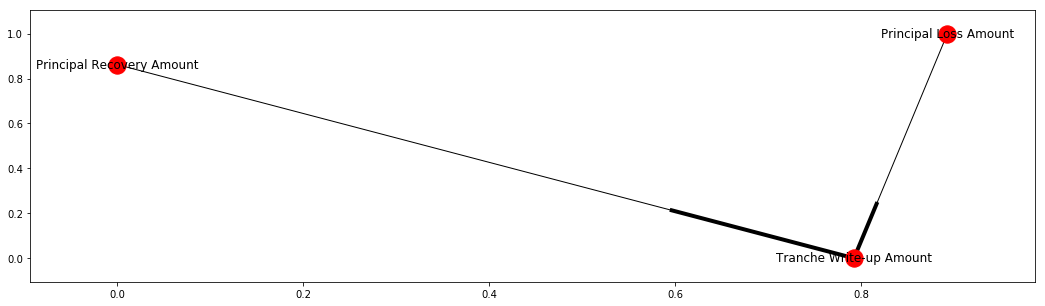

In [134]:
make_draw_graph(term0,cleangraph,(18,5))

## Set up some automated acronyms for easy reading

In [88]:
def nocollision(f):
    cache = []
    # this time, we allow ourselves to clear the cache manually
    def _f(arg,reset=False):
        if reset: 
            cache.clear()
            return
        #print(cache)
        i = 0
        baseresult = f(arg)
        result = baseresult
        while result in cache:
            assert i < 100, 'Problems with arg %s, f(arg) %s, and i %i' %(arg,result,i)
            #print(result)
            result = baseresult + str(i)
            i+=1
        cache.append(result)
        return result
    return _f
print(term0)

@nocollision
def acro(term): return gutils.acro(term)

print([acro(term_) for term_ in 'Principal Amount;Private Amount;Press Amonia'.split(';')])
print([acro(term_) for term_ in 'Principal Amount;Private Amount;Press Amonia'.split(';')])
acro(term0,1) # resets ('clears') the cache to an empty list
print([acro(term_) for term_ in 'Principal Amount;Private Amount;Press Amonia'.split(';')])

Tranche Write-up Amount
['PrAm', 'PrAm0', 'PrAm1']
['PrAm2', 'PrAm3', 'PrAm4']
['PrAm', 'PrAm0', 'PrAm1']


## Make an acronym dictionary and reverse dictionary.

In [94]:
acro('',reset = 1) # empty the cache
acrodict = dict([k,acro(k)] for k in termdict.keys()) # a dcitionary
racrodict = dict(((v,k) for k,v in acrodict.items()))
list(acrodict.items())[:5]#,racrodict['RCRNot']

[('RCR Notes', 'RCRNot'),
 ('Exchangeable Notes', 'ExcNot'),
 ('Dealer', 'De'),
 ('Additional Information', 'AddInf'),
 ('Qualified Institutional Buyers', 'QuInsBuy')]

In [96]:
len(cleangraph),len(graph)

(160, 192)

In [97]:
term0,'full graph',graph.in_edges(term0),'cleaned graph', cleangraph.in_edges(term0)

('Tranche Write-up Amount',
 'full graph',
 [('Principal Recovery Amount', 'Tranche Write-up Amount'),
  ('Payment Date', 'Tranche Write-up Amount'),
  ('Principal Loss Amount', 'Tranche Write-up Amount')],
 'cleaned graph',
 [('Principal Recovery Amount', 'Tranche Write-up Amount'),
  ('Principal Loss Amount', 'Tranche Write-up Amount')])

In [98]:
cleangraph.in_edges('Credit Event')

[]

In [99]:
# Confirm values 
term = 'Senior Reduction Amount'
term0 = 'Tranche Write-up Amount' # a second term
cleangraph.in_edges(term)

[('Delinquency Test', 'Senior Reduction Amount'),
 ('Scheduled Principal', 'Senior Reduction Amount'),
 ('Unscheduled Principal', 'Senior Reduction Amount'),
 ('Recovery Principal', 'Senior Reduction Amount'),
 ('Minimum Credit Enhancement Test', 'Senior Reduction Amount')]

In [100]:
#How to make a tentative formula, for editing and encoding
get_formula = lambda term,line=False,g=cleangraph: dlm[0].join((gutils.acro(term),'['+term+']')) + dlm[0] +'('+ dlm[1].join((gutils.acro(edge[0]) 
                                                        for edge in g.in_edges(term)) )+')'+ ("\n" if line else '')
get_formula(term,1)

get_formula_indent = lambda x,indent=0: '\t'*indent + get_formula(x)
term0, get_formula_indent(term0,2)

('Tranche Write-up Amount',
 '\t\tTrWrAm: [Tranche Write-up Amount]: (PrRecAm, PrLosAm)')

In [101]:
func,cum_form = decf(lambda x: x, lambda x: ([x+1],))
print(cum_form)

[]


In [102]:
func,cum_form = decf(get_formula_indent,lambda term,it: ([indedge[0],it+1]
                for indedge in cleangraph.in_edges(term)))
func(term0,0)
cum_form[:3]

['TrWrAm: [Tranche Write-up Amount]: (PrRecAm, PrLosAm)',
 '\tPrRecAm: [Principal Recovery Amount]: (CrEvNetGa, NetLiqPr, CrEvNetLos)',
 '\t\tCrEvNetGa: [Credit Event Net Gain]: (CrEvUPB, NetLiqPr, CurAccRat)']

## Write the pre-formula to file

In [106]:
if 1:
    with open('formula_dict_clean0.txt','w') as f:
        for line in cum_form: f.write(line+"\n")

## Check that empty formulae should be empty

In [104]:
for term_ in 'LiqPr CrEvUPB LiqPr'.split():
    print(termdict[racrodict[term_]])

[(1856, 'The "Liquidation Proceeds" with respect to a Credit Event Reference Obligation represent all cash amounts (including sales proceeds, net of selling expenses) received in connection with the liquidation of the Credit Event Reference Obligation.')]
[(1854, 'The "Credit Event UPB" with respect to any Credit Event Reference Obligation is the unpaid principal balance thereof as of the end of the Reporting Period related to the Payment Date that it became a Credit Event Reference Obligation.')]
[(1856, 'The "Liquidation Proceeds" with respect to a Credit Event Reference Obligation represent all cash amounts (including sales proceeds, net of selling expenses) received in connection with the liquidation of the Credit Event Reference Obligation.')]


In [108]:
get_formula('LiqPr')

'Liq: [LiqPr]: ()'

In [105]:
termdict[racrodict['ModEv']]

[(1857,
  'A "Modification Event" with respect to any Reference Obligation is a forbearance or certain mortgage rate modifications relating to such Reference Obligation, it being understood that in the absence of a forbearance or certain mortgage rate modifications, a term extension on a Reference Obligation will not constitute a Modification Event.'),
 (1858,
  'In addition, a mortgage rate modification that results in an increased mortgage rate with respect to any Reference Obligation (after giving effect to all scheduled mortgage rate modifications thereon) will not constitute a "Modification Event." For example, in the case of a mortgage rate modification that provides for a mortgage rate reduction from 4% to 2% followed by a future step-up in the mortgage rate from 2% to 5%, the modification will not be treated as a "Modification Event." By contrast, in the case of a mortgage rate modification that provides for a mortgage rate reduction from 4% to 2% followed by a future step-up i

In [107]:
get_formula('ModEv')

'Mod: [ModEv]: ()'